<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#K-Means-Clustering" data-toc-modified-id="K-Means-Clustering-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>K-Means Clustering</a></span></li><li><span><a href="#Label-Powerset" data-toc-modified-id="Label-Powerset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Label Powerset</a></span><ul class="toc-item"><li><span><a href="#TF-IDF-+-Linear-SVC" data-toc-modified-id="TF-IDF-+-Linear-SVC-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>TF-IDF + Linear SVC</a></span></li><li><span><a href="#TF-IDF-+-RandomForest-Classifier" data-toc-modified-id="TF-IDF-+-RandomForest-Classifier-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>TF-IDF + RandomForest Classifier</a></span></li><li><span><a href="#Count-Veroizer-+-Linear-SVC" data-toc-modified-id="Count-Veroizer-+-Linear-SVC-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Count Veroizer + Linear SVC</a></span></li><li><span><a href="#TF-IDF-+-Naive-Bayes" data-toc-modified-id="TF-IDF-+-Naive-Bayes-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>TF-IDF + Naive Bayes</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from helper_functions import *


## Modeling 
**데이터 불러오기**

In [4]:
mydata_train = pd.read_csv('./Data/merged/Prepossed_data_train_shuffled.csv')
mydata_test = pd.read_csv('./Data/merged/Prepossed_data_test_shuffled.csv')
mydata =  pd.read_csv('./Data/merged/Prepossed_data.csv')
#mydata = mydata.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
#mydata_train = mydata_train.drop(['Unnamed: 0.1'], axis = 1)
#mydata_test = mydata_test.drop(['Unnamed: 0.1'], axis = 1)

train_X, train_y = mydata_train['Plot'], mydata_train.drop(['BID', 'Plot'], axis=1)
test_X, test_y = mydata_test['Plot'], mydata_test.drop(['BID', 'Plot'], axis=1)

category_columns = train_y.columns

,BID,Plot,math,constructive algorithm,search,brute force,geometry,string,data structures,sortings,dp
0,1/A,theatre square capital city berland rectangula...,1,0,0,0,0,0,0,0,0
1,10/B,cinema hall berland rectangle row seat odd row...,0,0,0,0,0,0,0,0,1
2,10/D,problem differs online contest sequence called...,0,0,0,0,0,0,0,0,1
3,1000/A,codehorses hosted second codehorses cup year p...,0,0,0,0,0,0,0,1,0
4,1000/B,recently bought brand new smart lamp programmi...,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3949,999/B,string length encrypted following algorithm it...,0,0,0,0,0,0,0,0,0
3950,999/C,given string consisting lowercase latin letter...,0,0,0,0,0,0,0,0,0
3951,999/D,given array consisting positive guaranteed div...,0,0,0,0,0,0,1,1,0
3952,999/E,city road berland road connects pair city road...,0,0,0,0,0,0,1,1,0


### K-Means Clustering

In [5]:
print('Number of unique labels = ', train_y.drop_duplicates().shape[0])

Number of unique labels =  167


2^15 가능한 조합 중 540개의 Unique 조합이 있기 때문에 K-Means를 이용하여 Cluster들을 알아본다

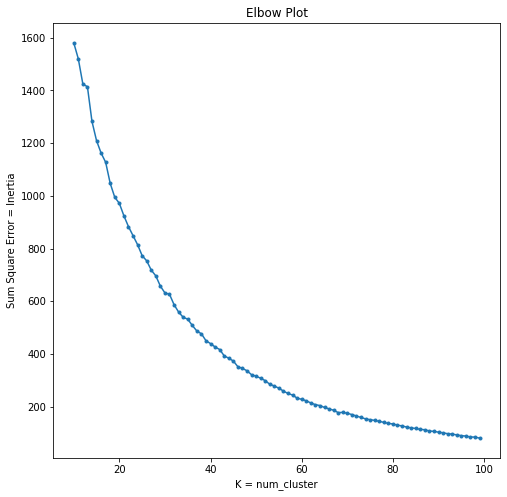

In [10]:
ss = [];
ks = range(10, 100)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    ss.append(kmeans.inertia_)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, ss, marker='.')
axes.set(xlabel='K = num_cluster', ylabel = 'Sum Square Error = Inertia', title = 'Elbow Plot')
plt.show()

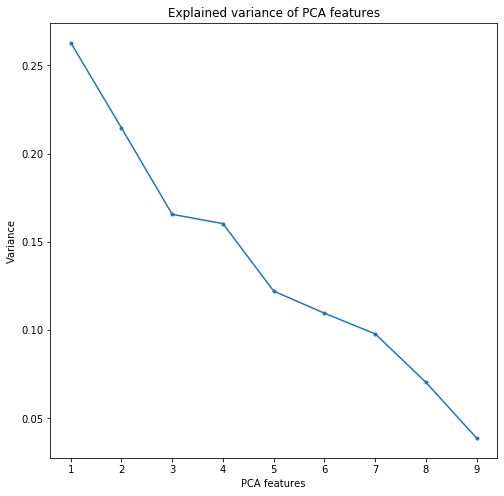

In [11]:
pca = PCA()
pca.fit(train_y)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(range(1, pca.n_components_+1), pca.explained_variance_, marker = '.')
axes.set(xlabel = 'PCA features', ylabel='Variance', title='Explained variance of PCA features')
plt.show()

In [12]:
ks = [50, 60, 65, 70, 75, 90, 100]
f1_score = []
thresh = 0.85
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    cluster_center = pd.DataFrame(columns=train_y.columns)
    for cluster_id in range(k):
        cluster_center.loc[cluster_id] = (kmeans.cluster_centers_[cluster_id]>=thresh)*1

    for idx, col in enumerate(train_y.columns):
        max_idx = kmeans.cluster_centers_[:,idx].argmax()
        max_value = kmeans.cluster_centers_[:,idx].max()
        if max_value<thresh:
            cluster_center.loc[max_idx, col] = 1
    
    y_pred = pd.DataFrame(columns=train_y.columns, index=train_y.index)
    for idx in range(k):
        y_pred.loc[labels==idx,:] = cluster_center.loc[idx,:].values

    result = accuracy(train_y, y_pred)
    f1_score.append(result.loc['Avg/Total', 'F1-Score'])

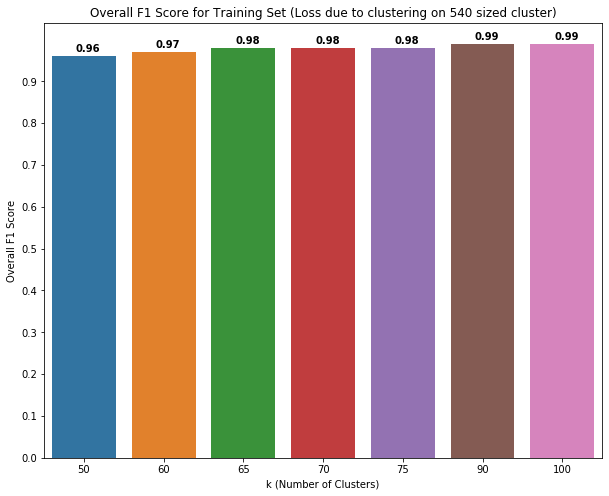

In [13]:

f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(x=ks, y=f1_score, axes=ax)
ax.set(ylabel='Overall F1 Score', xlabel='k (Number of Clusters)')
ax.set(title='Overall F1 Score for Training Set (Loss due to clustering on 540 sized cluster)')
plt.yticks(list(np.arange(0, 1, 0.1)))
for idx, val in enumerate(f1_score):
    ax.text(idx-0.1, val + 0.01,  str(val), color='black', fontweight='bold')
plt.show()

### Label Powerset
레이블간의 Correlation를 염두에 두는 방법으로, 레이블들의 모든 조합들에 대하여 Predict를 한다. (2^15)
#### TF-IDF + Linear SVC
**모든 조합 사용**

In [14]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [15]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.5],
                'tfidf__ngram_range': [(1, 2)],
                'tfidf__min_df': [2],
                'clf__C': [5, 10, 20, 50, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.370, total=   1.3s
[CV] clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=nan, total=   1.4s
[CV] clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.373, total=   1.4s
[CV] clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=nan, total=   1.5s
[CV] clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.369, total=   1.6s
[CV] clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.1s remaining:    0.0s


[CV]  clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=nan, total=   1.8s
[CV] clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.370, total=   2.1s
[CV] clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.2s remaining:    0.0s
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.4s remaining:    0.0s


[CV]  clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=nan, total=   2.2s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.368, total=   2.9s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.3s remaining:    0.0s
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.1s finished
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=nan, total=   2.7s

Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', LinearSVC(C=5, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]

Applying best classifier on test data:
<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.51,0.47,0.49,261.0
constructive algorithm,0.28,0.29,0.28,126.0
search,0.25,0.21,0.23,117.0
brute force,0.25,0.22,0.23,132.0
geometry,0.46,0.61,0.52,38.0
string,0.54,0.61,0.58,72.0
data structures,0.57,0.56,0.56,277.0
sortings,0.48,0.42,0.45,259.0
dp,0.41,0.44,0.42,195.0
Avg/Total,0.44,0.43,0.43,1477.0


In [16]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.53,0.44,0.48,261.0
constructive algorithm,0.31,0.25,0.28,126.0
search,0.28,0.20,0.23,117.0
brute force,0.22,0.17,0.19,132.0
geometry,0.48,0.55,0.51,38.0
string,0.58,0.54,0.56,72.0
data structures,0.58,0.55,0.57,277.0
sortings,0.51,0.40,0.45,259.0
dp,0.41,0.39,0.40,195.0
Avg/Total,0.46,0.40,0.42,1477.0


**클러스터 사용**

(데이터 개수 X 레이블) 행렬을 k 클러스터개로 나누는 K-Means 방법을 사용
- train_y의 레이블이 (0 ~ k)개로 더 작아짐
- 별도의 Mapping 함수 필요

In [17]:
ks = [85]
f1_score = []
thresh = 0.85
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    train_y_cluster_labels = pd.Series(labels, index=train_y)
    cluster_center = pd.DataFrame(columns=train_y.columns)
    for cluster_id in range(k):
        cluster_center.loc[cluster_id] = (kmeans.cluster_centers_[cluster_id]>=thresh)*1

    for idx, col in enumerate(train_y.columns):
        max_idx = kmeans.cluster_centers_[:,idx].argmax()
        max_value = kmeans.cluster_centers_[:,idx].max()
        if max_value<thresh:
            cluster_center.loc[max_idx, col] = 1
    
    train_y_genre_labels = pd.DataFrame(columns=train_y.columns, index=train_y.index)
    for idx in range(k):
        train_y_genre_labels.loc[labels==idx,:] = cluster_center.loc[idx,:].values

    result = accuracy(train_y, train_y_genre_labels)

In [18]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.25, 0.5, 0.75],
                'tfidf__ngram_range': [(1, 2)],
                'tfidf__min_df': [1, 2, 5],
                'clf__C': [1, 10, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.162, total=   1.5s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.124, total=   1.5s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.157, total=   1.0s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.137, total=   1.0s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.1s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.144, total=   0.9s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.128, total=   0.8s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.8s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.164, total=   1.4s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.3s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.124, total=   1.5s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.8s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.161, total=   1.0s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.8s remaining:    0.0s


[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.136, total=   1.0s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.144, total=   0.8s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.127, total=   0.8s
[CV] clf__C=1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.163, total=   1.5s
[CV] clf__C=1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.125, total=   1.6s
[CV] clf__C=1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1,

/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.204, total=   5.4s
[CV] clf__C=100, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.194, total=   5.2s
[CV] clf__C=100, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.189, total=   2.5s
[CV] clf__C=100, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.191, total=   2.1s
[CV] clf__C=100, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.197, total=   1.6s
[CV] clf__C=100, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.164, total=   1.6s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.215, total=   5.8s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.190, total=   5.6s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.037, total=   2.4s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.038, total=   2.3s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.196, total=   1.7s
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.171, total=   1.7s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.210, total=   5.8s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.192, total=   5.6s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.037, total=   2.5s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.038, total=   2.3s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.196, total=   1.7s
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.171, total=   1.7s


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.8min finished
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]

Applying best classifier on test data:
<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.55,0.43,0.48,261.0
constructive algorithm,0.35,0.25,0.29,126.0
search,0.22,0.10,0.14,117.0
brute force,0.22,0.13,0.16,132.0
geometry,0.58,0.50,0.54,38.0
string,0.69,0.50,0.58,72.0
data structures,0.59,0.55,0.57,277.0
sortings,0.50,0.35,0.41,259.0
dp,0.39,0.32,0.35,195.0
Avg/Total,0.46,0.36,0.40,1477.0


In [19]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', LinearSVC(C=1, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.50,0.48,0.49,261.0
constructive algorithm,0.29,0.36,0.32,126.0
search,0.22,0.30,0.26,117.0
brute force,0.22,0.29,0.25,132.0
geometry,0.36,0.53,0.43,38.0
string,0.52,0.60,0.55,72.0
data structures,0.50,0.53,0.52,277.0
sortings,0.45,0.40,0.42,259.0
dp,0.38,0.47,0.42,195.0
Avg/Total,0.41,0.44,0.42,1477.0


In [20]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.55,0.44,0.49,261.0
constructive algorithm,0.35,0.25,0.29,126.0
search,0.27,0.17,0.21,117.0
brute force,0.25,0.17,0.20,132.0
geometry,0.53,0.50,0.51,38.0
string,0.67,0.46,0.55,72.0
data structures,0.57,0.54,0.56,277.0
sortings,0.53,0.38,0.44,259.0
dp,0.41,0.36,0.38,195.0
Avg/Total,0.47,0.38,0.42,1477.0


#### TF-IDF + RandomForest Classifier

In [21]:
train_y_cluster_labels = pd.DataFrame(columns=['Labels'], index=train_y.index)
train_y_cluster_labels['Labels'] = train_y.groupby(list(category_columns)).ngroup()
cluster_center = pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [22]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', RandomForestClassifier(n_estimators=500, max_depth=70, max_features='sqrt', n_jobs=4))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.61,0.56,0.59,261.0
constructive algorithm,1.00,0.01,0.02,126.0
search,0.33,0.01,0.02,117.0
brute force,0.38,0.02,0.04,132.0
geometry,0.82,0.24,0.37,38.0
string,0.79,0.53,0.63,72.0
data structures,0.73,0.52,0.61,277.0
sortings,0.56,0.15,0.24,259.0
dp,0.38,0.02,0.03,195.0
Avg/Total,0.60,0.26,0.31,1477.0


#### Count Veroizer + Linear SVC
**모든조합사용**

In [23]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [24]:

pipeline = Pipeline([
                ('cvec', CountVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'cvec__max_df': [0.25, 0.5],
                'cvec__ngram_range': [(1, 1)],
                'cvec__min_df': [1, 2],
                'clf__C': [1, 10, 50, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.359, total=   1.1s
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.4s
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.359, total=   0.9s
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.2s
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.368, total=   1.0s
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.3s
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.9s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.364, total=   1.0s
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.1s remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.2s
[CV] clf__C=10, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.2s remaining:    0.0s


[CV]  clf__C=10, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.355, total=   1.1s
[CV] clf__C=10, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=10, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=10, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=10, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.352, total=   1.0s
[CV] clf__C=10, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=10, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=10, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=10, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.364, total=   1.0s
[CV] clf__C=10, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=10, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=10, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=10, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.361, total=   1.0s
[CV] clf__C=10, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=10, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=50, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=50, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.350, total=   1.0s
[CV] clf__C=50, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=50, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.0s
[CV] clf__C=50, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=50, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.349, total=   0.9s
[CV] clf__C=50, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=50, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.0s
[CV] clf__C=50, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=50, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.362, total=   1.0s
[CV] clf__C=50, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=50, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=50, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=50, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.361, total=   0.9s
[CV] clf__C=50, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=50, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=100, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.354, total=   1.0s
[CV] clf__C=100, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=100, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.1s
[CV] clf__C=100, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.350, total=   0.9s
[CV] clf__C=100, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=100, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.0s
[CV] clf__C=100, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.359, total=   1.0s
[CV] clf__C=100, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)


[CV]  clf__C=100, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=nan, total=   1.0s
[CV] clf__C=100, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  clf__C=100, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.360, total=   0.9s
[CV] clf__C=100, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   33.5s finished
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[CV]  clf__C=100, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=nan, total=   1.0s

Best parameters set:
[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.25, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)), ('clf', LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]

Applying best classifier on test data:
<class 'pandas.core.series.Series'>


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Precision,Recall,F1-Score,Support
math,0.50,0.50,0.50,261.0
constructive algorithm,0.32,0.22,0.26,126.0
search,0.25,0.13,0.17,117.0
brute force,0.28,0.20,0.23,132.0
geometry,0.56,0.47,0.51,38.0
string,0.66,0.43,0.52,72.0
data structures,0.55,0.52,0.53,277.0
sortings,0.48,0.39,0.43,259.0
dp,0.39,0.30,0.34,195.0
Avg/Total,0.45,0.37,0.40,1477.0


**클러스터사용**

In [25]:

pipeline = Pipeline([
                ('cvec', CountVectorizer(max_df=0.75, min_df=1, ngram_range=(1, 1))),
                ('clf', LinearSVC(C=1, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Precision,Recall,F1-Score,Support
math,0.48,0.49,0.48,261.0
constructive algorithm,0.33,0.21,0.25,126.0
search,0.15,0.08,0.10,117.0
brute force,0.28,0.17,0.21,132.0
geometry,0.52,0.34,0.41,38.0
string,0.62,0.43,0.51,72.0
data structures,0.58,0.55,0.56,277.0
sortings,0.49,0.38,0.43,259.0
dp,0.38,0.28,0.32,195.0
Avg/Total,0.44,0.36,0.39,1477.0


#### TF-IDF + Naive Bayes
**모든조합사용**

In [26]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [27]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB(fit_prior=True, class_prior=None))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.25, 0.5, 0.75],
                'tfidf__ngram_range': [(1, 1)],
                'tfidf__min_df': [1, 2, 5, 10],
                'clf__alpha': [0.001, 0.01, 0.1, 1]
            }

overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  reca

/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWa

/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:102: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
/Users/jonghyun/Desktop/Projects/algorithm_recommenation_with_ml_and_dl/helper_functions.py:103: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
/Users/jonghyun/anaconda3/envs/website/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set s


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))]

Applying best classifier on test data:
<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.57,0.43,0.49,261.0
constructive algorithm,0.38,0.09,0.14,126.0
search,0.50,0.07,0.12,117.0
brute force,0.33,0.08,0.13,132.0
geometry,0.91,0.26,0.41,38.0
string,0.72,0.29,0.42,72.0
data structures,0.59,0.51,0.54,277.0
sortings,0.53,0.28,0.37,259.0
dp,0.33,0.12,0.17,195.0
Avg/Total,0.51,0.28,0.34,1477.0


In [28]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.58,0.45,0.50,261.0
constructive algorithm,0.46,0.09,0.15,126.0
search,0.46,0.05,0.09,117.0
brute force,0.38,0.08,0.13,132.0
geometry,0.83,0.26,0.40,38.0
string,0.73,0.31,0.43,72.0
data structures,0.61,0.52,0.56,277.0
sortings,0.54,0.29,0.37,259.0
dp,0.33,0.11,0.16,195.0
Avg/Total,0.52,0.28,0.34,1477.0


In [29]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

<class 'pandas.core.series.Series'>


,Precision,Recall,F1-Score,Support
math,0.58,0.45,0.50,261.0
constructive algorithm,0.46,0.09,0.15,126.0
search,0.46,0.05,0.09,117.0
brute force,0.38,0.08,0.13,132.0
geometry,0.83,0.26,0.40,38.0
string,0.73,0.31,0.43,72.0
data structures,0.61,0.52,0.56,277.0
sortings,0.54,0.29,0.37,259.0
dp,0.33,0.11,0.16,195.0
Avg/Total,0.52,0.28,0.34,1477.0
